## Image Processing

In this notebook I will process the image features for the each of the images in the database. I will use the following method flow:

1. The images will intially be resized to 200x200 pixels, this will standardise them in order to create histograms that can be compared against each other. 
2. The 3 most dominant colours will be found for each image. I will complete this by applying K-Mean clustersing to the RGB values for each image and using the centroid values as the dominiant colours. I will ensure to ignore the white background.
3. Generate Texture Histograms this will be completed in a seperate workbook entitled Image_Histogram_Building.ipynb, the date generated will be saved to a csv file to be used for EDA. Towards the end of this notebook I have looked at applying weighting factors to shoes from different retailers. This is explained in further detail below.

In [2]:
import struct
import scipy
import scipy.misc
import scipy.cluster
from PIL import Image
import pandas as pd
from matplotlib.pyplot import imshow
%matplotlib inline
import numpy as np
from os import listdir
from sklearn.cluster import KMeans
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

## Resize Images for Texture Feature Processing

I have created 4 subfolders containing the images for each of the retailers respectively. The Location and folder names are given below.

Each of the images will be resized to 200x200 pixels, this is required to create histograms (a square image) that can be compared as well as this reducing the size of the image increases the processing time substantially. Initally the images are cropped into a square and then are resized.

In [22]:
Root_Location='/Users/annacrawford/Desktop/Images_Sort/'
Folders=['NAP','FAF','HAR','SFA']

In [6]:
for y in Folders:
    Location=''.join([Root_Location,y,'/'])
    files=[x for x in listdir(Location) if x[-4:]=='.jpg']
    for x in files:
        ## print 'Processing image :',x
        dloc=''.join([Location,x])
        im=Image.open(dloc)
        w,h=im.size
        ## Images are cropped into a square
        crop_im=im.crop((0,(h-w)/2,w,h-((h-w)/2)))
        resize = crop_im.resize((200, 200))
        resize.save(dloc)

In [45]:
temp=[x for x in listdir('/Users/annacrawford/Desktop/Images_Sort/SFA') if x[-4:]=='.jpg']

In [46]:
len(temp)

1454

In [47]:
## NAP - 1049
## FAF - 6219
## HAR - 1032
## SFA - 1454
total=1049+6219+1032+1454
total

9754

## Dominant Colours

Using K-means clustering I am able to find the most dominant colours by creating an array of the image pixels in RGB format, then once the clusters are found the centroids are taken as the colours. The clusters are ordered by size and then the resulting RGBs are appended to a list that will be used to form a dataframe.

An example of a clustered image can be found below, with only the 3 most dominant colours.

I have included a try and except method as I noticed that a number of the pictures, when resized turned into a b&w image, this has issues when the the function below is reshaping the image to deteremine the various colour clusters as it expects 3 variables for each pixel (Red, Green and Blue) but instead gets a greyscale value.

In [23]:
Colour1=[]
Colour2=[]
Colour3=[]
Image_Number=[]

km=KMeans(n_clusters=5)

for q in Folders:
    Location=''.join([Root_Location,q,'/'])
    files=[x for x in listdir(Location) if x[-4:]=='.jpg']
    for x in files:
        try:
            dloc=''.join([Location,x])
            im = Image.open(dloc)
            ar = scipy.misc.fromimage(im)
            shape = ar.shape
            ar = ar.reshape(scipy.product(shape[:2]), shape[2])
            output=km.fit_transform(ar)
            codes=(km.cluster_centers_).astype('int')
            Non_Bg=[]
            for z in codes:
                White=True
                for y in z:
                    if y<250:
                        White=False
                if White==False:
                      Non_Bg.append(z)
                        
            Image_Number.append(x.split('_')[1])
            Colour1.append(Non_Bg[0])
            Colour2.append(Non_Bg[1])
            Colour3.append(Non_Bg[2])
        except:
            print 'Error processing image :',x

Error processing image : _2989_a.jpg
Error processing image : _4497_a.jpg
Error processing image : _7781_a.jpg
Error processing image : _9911_a.jpg


In [24]:
## Create a Dataframe from the three most dominant colour lists
Col_1=pd.DataFrame(data=Colour1,columns=['Red','Green','Blue'])
Col_2=pd.DataFrame(data=Colour2,columns=['Red_2','Green_2','Blue_2'])
Col_3=pd.DataFrame(data=Colour3,columns=['Red_3','Green_3','Blue_3'])
Img_Num=pd.DataFrame(data={'ID':Image_Number})
Colours=pd.merge(Col_1,Col_2,left_index=True,right_index=True)
Colours=pd.merge(Colours,Col_3,left_index=True,right_index=True)
Colours=pd.merge(Colours,Img_Num,left_index=True,right_index=True)
Colours.head()

,Red,Green,Blue,Red_2,Green_2,Blue_2,Red_3,Green_3,Blue_3,ID
0,51,49,57,107,106,108,29,28,33,1557
1,170,112,73,125,79,46,197,141,106,1558
2,179,152,126,77,62,53,154,125,100,1559
3,25,21,21,88,86,86,46,42,42,1560
4,146,144,140,242,241,239,192,190,187,1561


In [25]:
## Save the resulting dataframe to a csv file
Colours.to_csv('/Users/annacrawford/Colin/GA/Week1/DSI_LDN_1_LESSON_NOTES/projects/capstone/Colour_Features.csv',index=False)

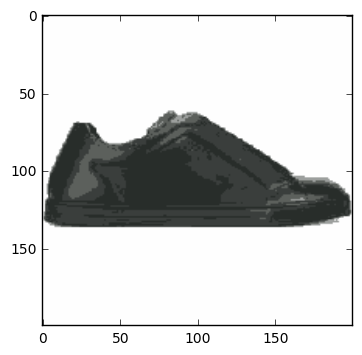

In [53]:
## Below is an example image with the colours separted into the 4 most dominant colors.
c = ar.copy()
for i, code in enumerate(codes):
    c[scipy.r_[scipy.where(km.labels_==i)],:] = code
imshow(c.reshape(*shape))

## Texture Comparison

In this section I will compare the histograms of all the shoes in a sample set of 80 images (20 from each retailer) against each other. There are two objectives I would like to achieve; 
1. The first is to see if the texture histograms and histogram distances are correctly finding similar shoes. 
2. The second is to determine if there are different weighting adjustments required for groups of shoes from different retailers. For example I expect shoes from one retailer to match better (have a shorter distance) to those from the same retailer as the pictures will be in a similar format (lightening, angle of picture, one shoe or two etc). I want to to see if I can match shoes from differnt retailer groups by applying a weighting to shoes from various sets.

In [31]:
## Read the csv of image histograms from the sample set.
Textures=pd.read_csv('Texture_Features.csv',)

In [32]:
Textures.head()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,1.0,1.0,0.0,0.0,0.5,6.5,0.0,10.0,1.5,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5
1,1.0,0.0,1.0,0.0,0.0,2.0,0.0,14.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,0.0,0.0,0.0,0.0,0.0,8.5,0.0,4.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
3,2.0,0.0,3.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,0.5,2.5,0.0,1.0,0.0,7.5,0.0,6.5,1.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.5


In [38]:
## Generating a list of each of the shoe IDs in order to open the correct images when comparing the closest matches.
onlyfiles = [x for x in listdir('/Users/annacrawford/Desktop/Images') if x[-4:]=='.jpg']

Loc1= [i for i, s in enumerate(onlyfiles) if '1898' in s][1]
Loc2= [i for i, s in enumerate(onlyfiles) if '3526' in s][0]
Loc3= [i for i, s in enumerate(onlyfiles) if '6287' in s][0]
Loc4= [i for i, s in enumerate(onlyfiles) if '11379' in s][0]

sample_1=onlyfiles[Loc1:Loc1+100]
sample_2=onlyfiles[Loc2:Loc2+100]
sample_3=onlyfiles[Loc3:Loc3+100]
sample_4=onlyfiles[Loc4:Loc4+100]
Samples=[sample_1,sample_2,sample_3,sample_4]
SL=sample_1+sample_2+sample_3+sample_4

In [33]:
## This function compares each histogram in the dataset with all of the others, using 1 of 6 distance metrics. 
## The function then returns an array of all of the distance metrics for each image against each other.
def Histogram_Compare(Array,Method):
    Length=len(Array)
    Output=np.zeros((Length,Length))
    for x in range(Length):
        for y in range(Length):
            if x>=y:
                Output[x,y]=np.nan
            else:
                Shoe1=np.reshape(Array.ix[x,:],(1500,1)).astype('float32')
                Shoe2=np.reshape(Array.ix[y,:],(1500,1)).astype('float32')
                Output[x,y]=cv2.compareHist(Shoe1,Shoe2,Method)
    return Output

In [34]:
## This function looks up input image IDs and displays the related image from the database. This is displayed in 
## a 5*2 grid.
def Top_Image_Plot(Array,Images,measure=0):
    Out_DF=pd.DataFrame(data=Array,columns=Images,index=Images)
    Out_DF['ind']=Out_DF.index
    
    if measure==1:
        temp=pd.melt(Out_DF,id_vars='ind').dropna().sort_values(by='value')
    else:
        temp=pd.melt(Out_DF,id_vars='ind').dropna().sort_values(by='value',ascending=False)
        
    fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10))=plt.subplots(5,2,figsize=(12,12))
    Image_List_Left=[ax1,ax3,ax5,ax7,ax9]
    Image_List_Right=[ax2,ax4,ax6,ax8,ax10]
    for axa,axb,i in zip(Image_List_Left,Image_List_Right,range(5)):
        imloc1=''.join(['/Users/annacrawford/Desktop/Images/',temp.iloc[i,0]])
        imloc2=''.join(['/Users/annacrawford/Desktop/Images/',temp.iloc[i,1]])
        im1=Image.open(imloc1)
        im2=Image.open(imloc2)
        axa.imshow(im1)
        axb.imshow(im2)
        axa.axis('off')
        axb.axis('off')

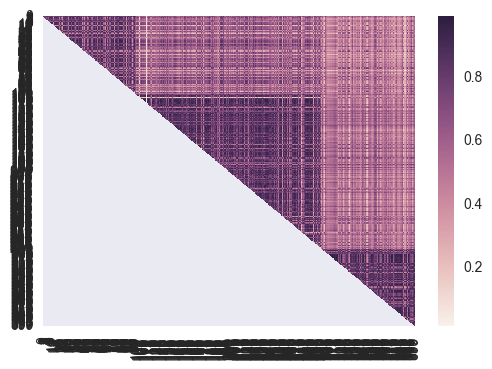

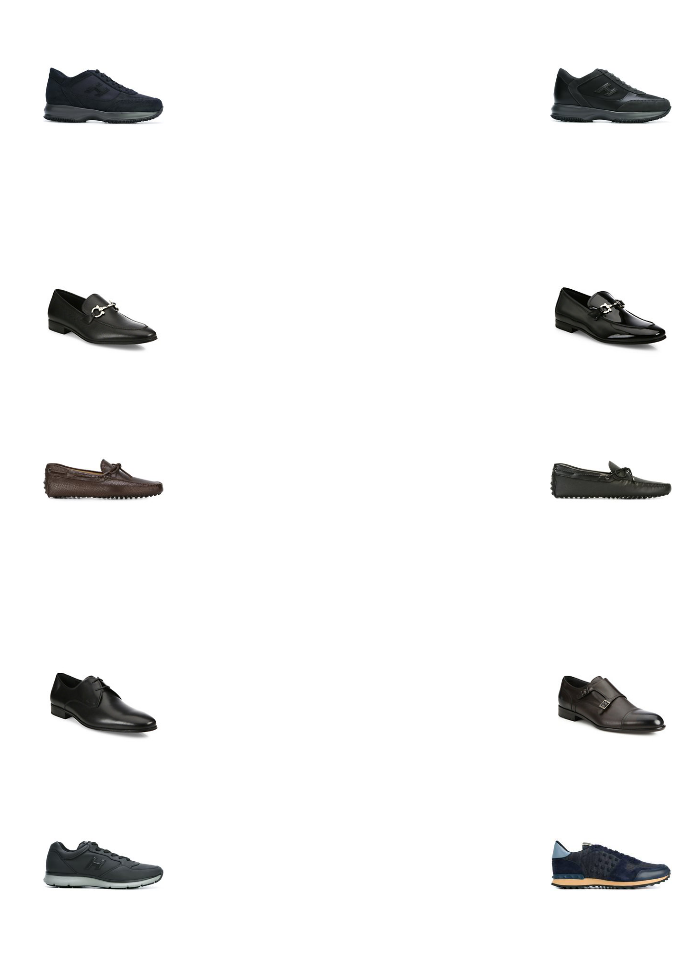

In [39]:
## Calculation of histogram distances, plotting a heat map and top five closest matches (Distance)
Output0=Histogram_Compare(Textures,0)
sns.heatmap(Output0)
Top_Image_Plot(Output0,SL)

From the images above it is clear that the method has worked sucessfully and images have been matched appropriatly, from the heat map we can see there are areas of higher closer and futher distances based on retailer groups, I will try and determine a weighting system to counteract this at a later point in this workbook.

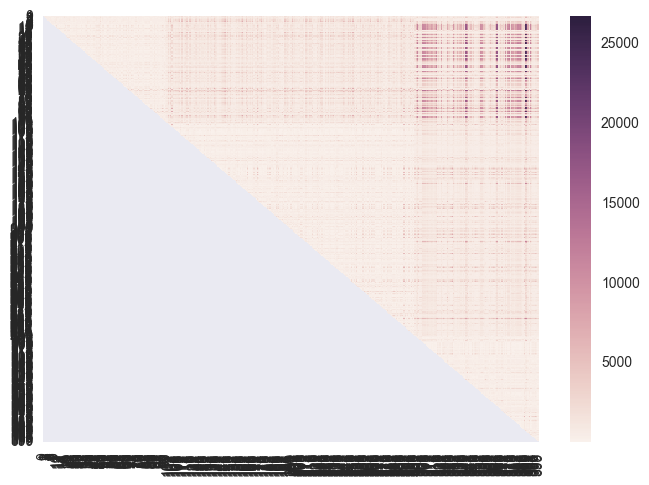

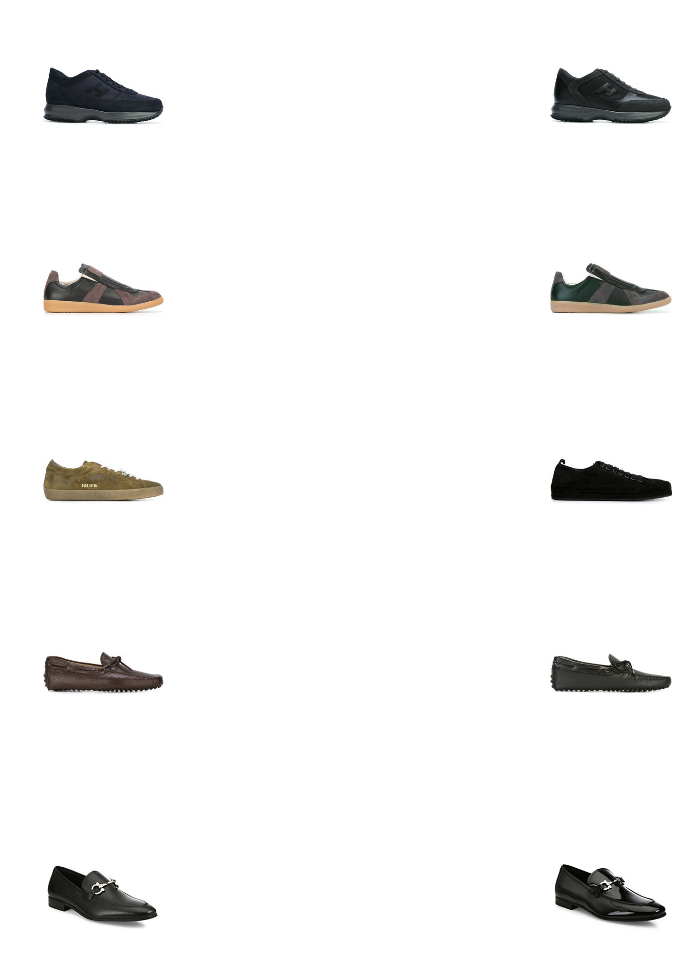

In [18]:
Output1=Histogram_Compare(Textures,1)
sns.heatmap(Output1)
Top_Image_Plot(Output1,SL,measure=1)

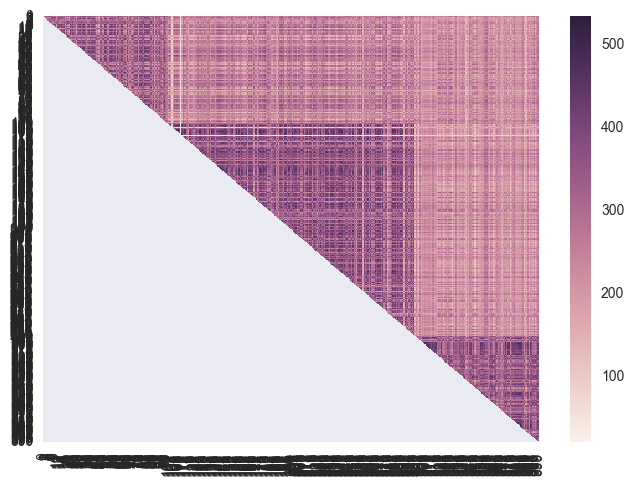

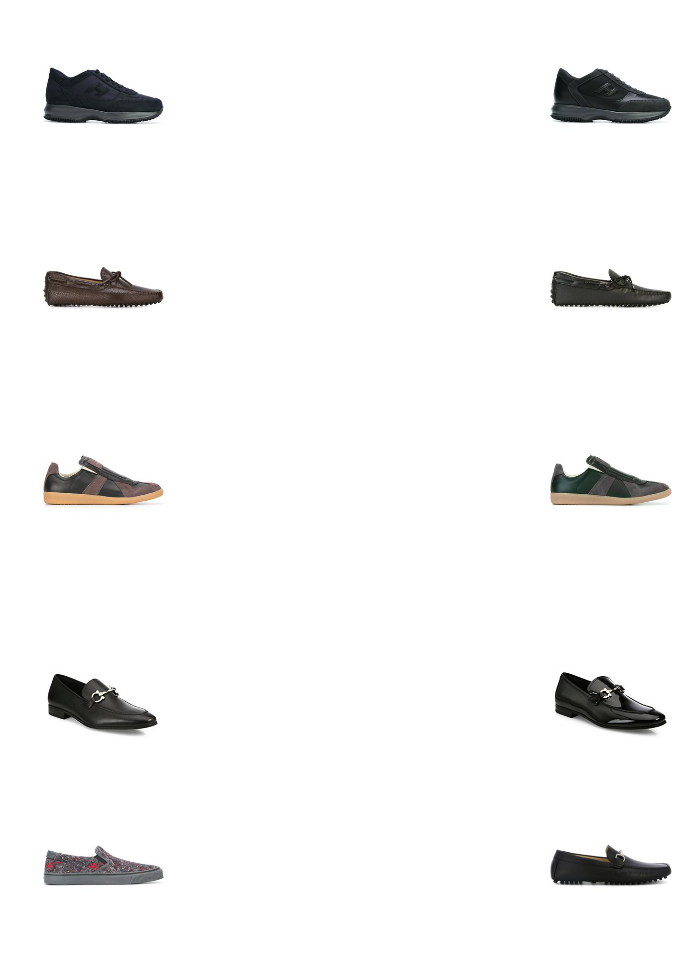

In [16]:
Output2=Histogram_Compare(Textures,2)
sns.heatmap(Output2)
Top_Image_Plot(Output2,SL)

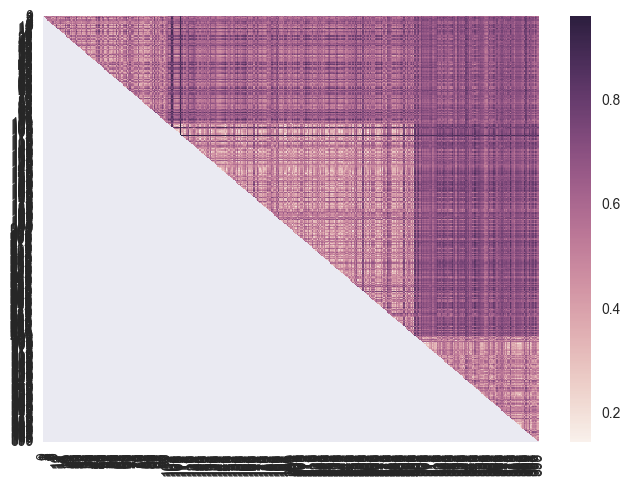

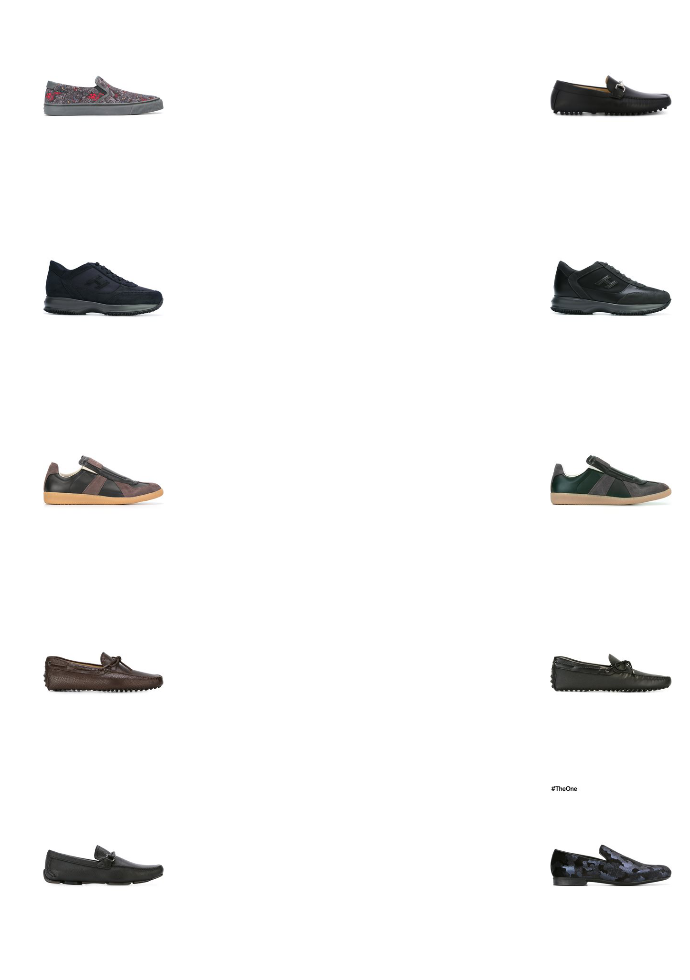

In [19]:
Output3=Histogram_Compare(Textures,3)
sns.heatmap(Output3)
Top_Image_Plot(Output3,SL,measure=1)

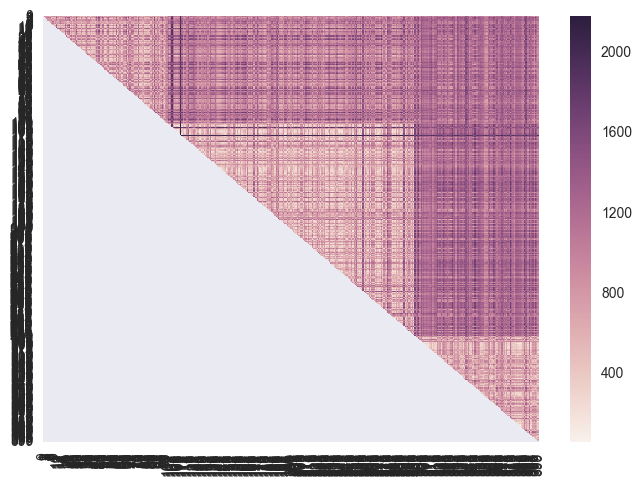

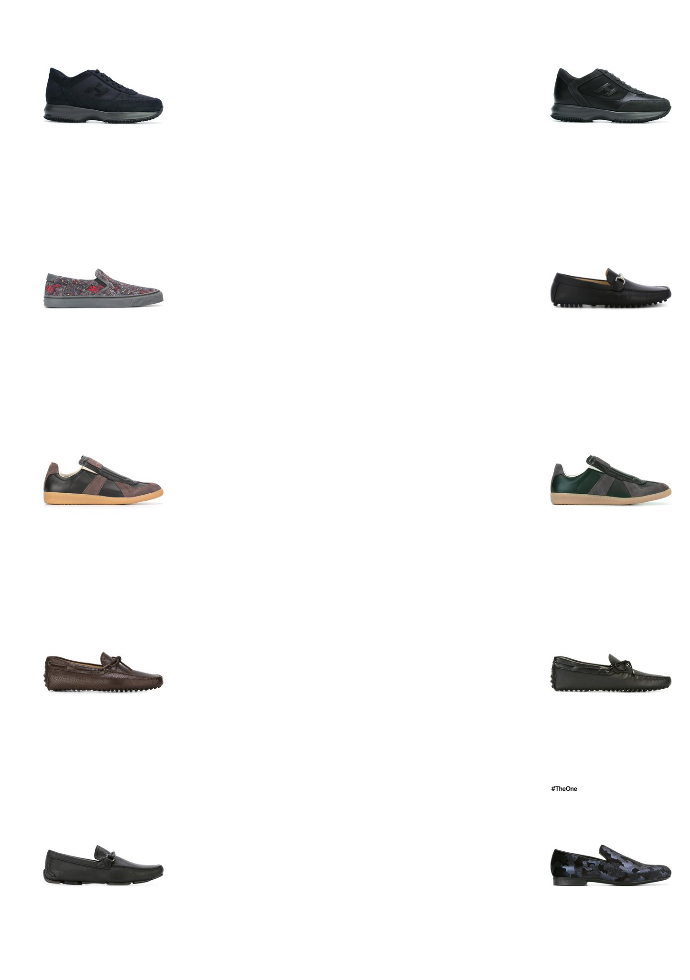

In [20]:
Output4=Histogram_Compare(Textures,4)
sns.heatmap(Output4)
Top_Image_Plot(Output4,SL,measure=1)

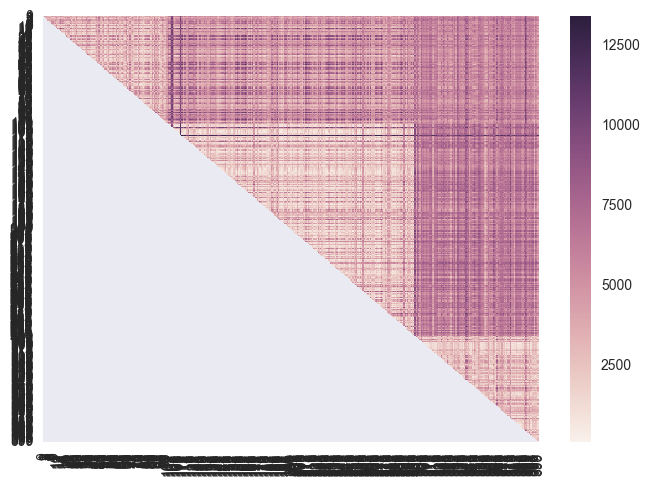

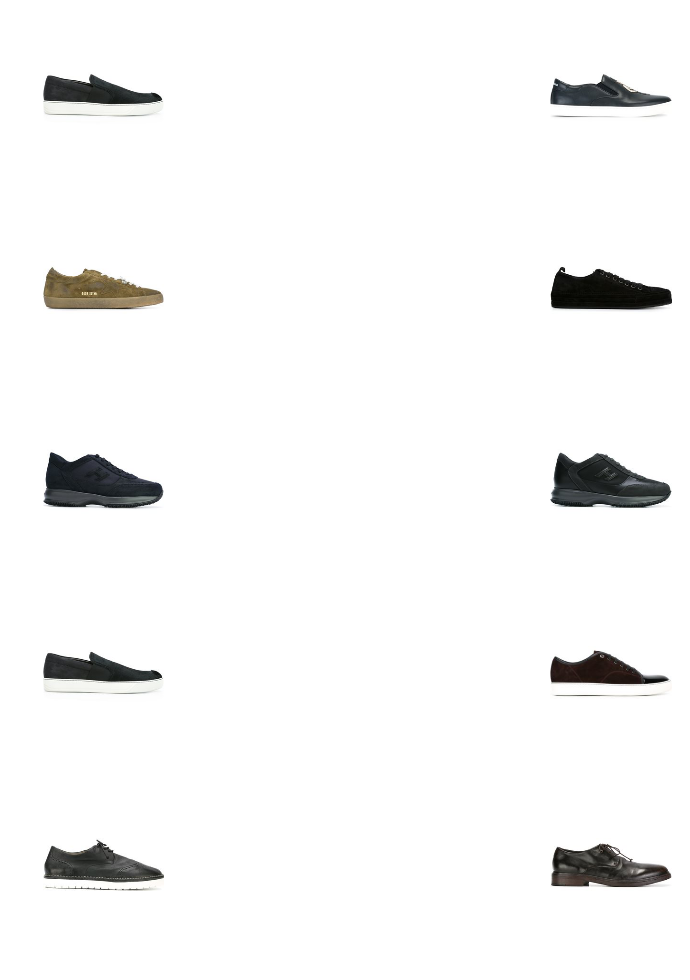

In [21]:
Output5=Histogram_Compare(Textures,5)
sns.heatmap(Output5)
Top_Image_Plot(Output5,SL,measure=1)

It is clear that all the distance metrics have provided good results, however we are only seeing the very top matches, and it is difficult to detemine which metric is working the best.
As noted above there is a strong relationship between certain retailers, none of the matches above have come from retailers that photographed their shoes at an angle.
The function below is used to normalise the difference between the images. It simiply averages the score for each segment (Harrods vs Farfetch etc) these mean values are then used as the weighting, and the matrix is deivided by its subset average. This in theory should normalize the data and hopefully provide shoes matching shoes from different angles. However as this only a data set of 20 shoes from each retailer it is quite a small sample so may not work very effectivly.

In [13]:
def Matrix_Normalise(Input,Grid_Length=[20,20,20,20]):
    Length=len(Input)
    if sum(Grid_Length)!=Length:
        print 'Grid length does not match input grid!'
        return
    y=0
    a=0
    Weighting_Grid=np.zeros((4,4))
    Input=Input.astype('float')
    Output_Grid=np.zeros((Length,Length)).astype('float')
    for b in range(len(Grid_Length)):
        for x in range(len(Grid_Length)):
                        
            if b==x:
                Elements=((Grid_Length[x]**2)-Grid_Length[x])/2
            else:
                Elements=Grid_Length[x]**2
            
            Segment_Average=np.sum(Input[a:a+Grid_Length[b],y:y+Grid_Length[x]])/Elements
            Weighting_Grid[b,x]=Segment_Average
            Output_Grid[a:a+Grid_Length[b],y:y+Grid_Length[x]]= Input[a:a+Grid_Length[b],y:y+Grid_Length[x]]/Segment_Average
            y+=Grid_Length[x]
        a+=Grid_Length[b]
        y=0
    print "Weighting:"
    print Weighting_Grid
    return Output_Grid

Weighting:
[[        nan  0.57074684  0.58209898  0.46854855]
 [        nan         nan  0.77163097  0.51601624]
 [        nan         nan         nan  0.51368366]
 [        nan         nan         nan         nan]]


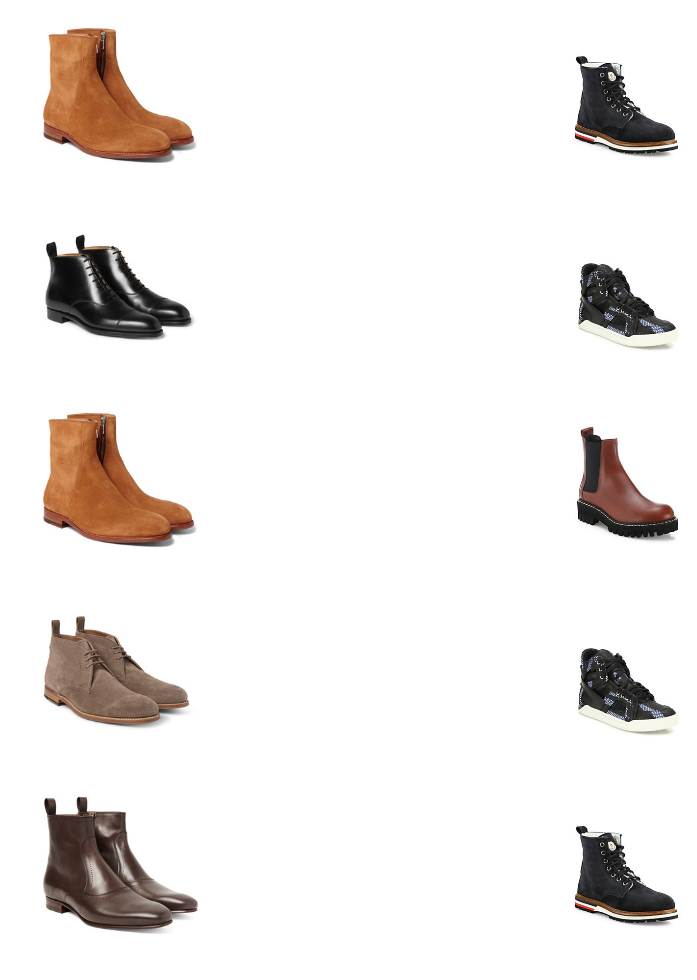

In [15]:
Norm0=Matrix_Normalise(Output0,[100,100,100,100])
Top_Image_Plot(Norm0,SL)

The weighted matching has now included shoes from the angled photo set and from two independent retailers (1 shoe vs 2 shoes). Even though all these shoes are boots of some type the matches do not seem that close. It also seems this metric has adjusted the weighting on boots disproportionally.

Weighting:
[[           nan  1338.63621671  1299.41044159  3023.69180697]
 [           nan            nan   605.73061211  1191.76099055]
 [           nan            nan            nan  1196.86316154]
 [           nan            nan            nan            nan]]


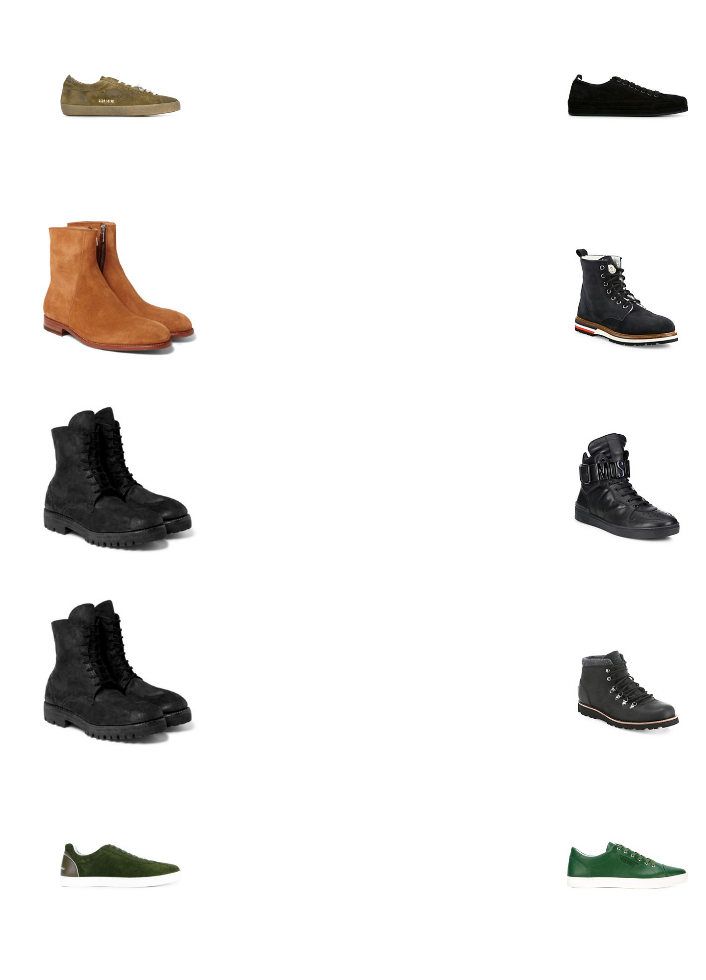

In [22]:
Norm1=Matrix_Normalise(Output1,[100,100,100,100])
Top_Image_Plot(Norm1,SL,measure=1)

This metric has not weighted boots matching as higly and most of the matches look quite good, however there are still no matches between shoes face on and at an angle.

Weighting:
[[       nan  240.4371   245.8437   215.7884 ]
 [       nan        nan  334.0807   209.63615]
 [       nan        nan        nan  209.2396 ]
 [       nan        nan        nan        nan]]


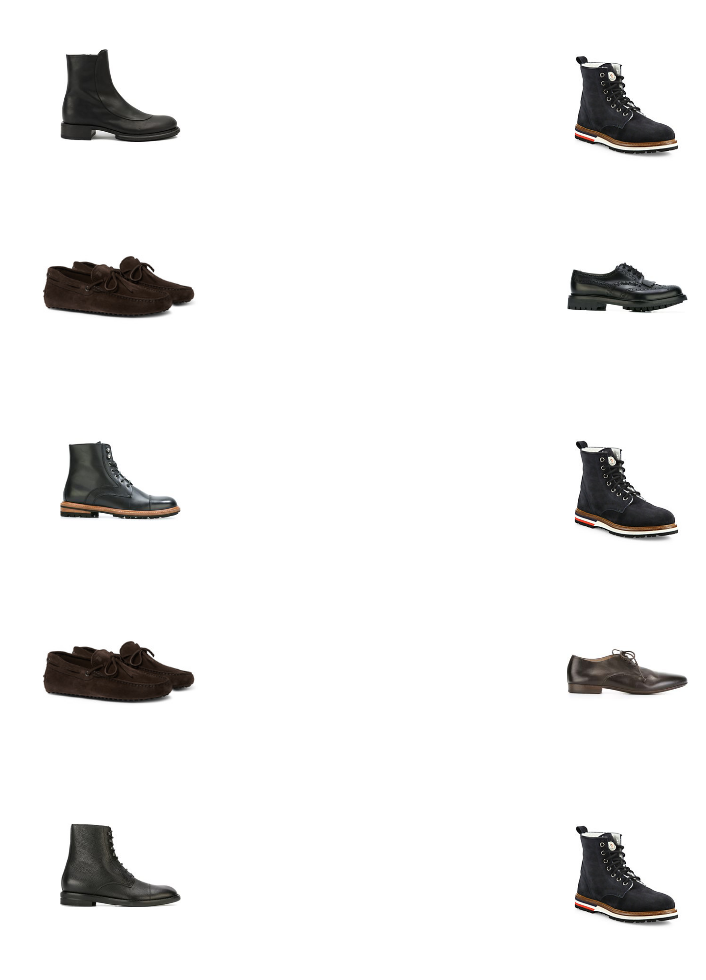

In [17]:
Norm2=Matrix_Normalise(Output2,[100,100,100,100])
Top_Image_Plot(Norm2,SL)

We can see above that finally some matches between images from their side and from an angle have been made, the weightings applied have worked sucessfully especially in the cases of the boots, ideally I do the weigthing calcualtion to the whole dataset, however this would prove very computationally time consuming.

Weighting:
[[        nan  0.63268451  0.62636302  0.6812936 ]
 [        nan         nan  0.49243941  0.69762508]
 [        nan         nan         nan  0.69650594]
 [        nan         nan         nan         nan]]


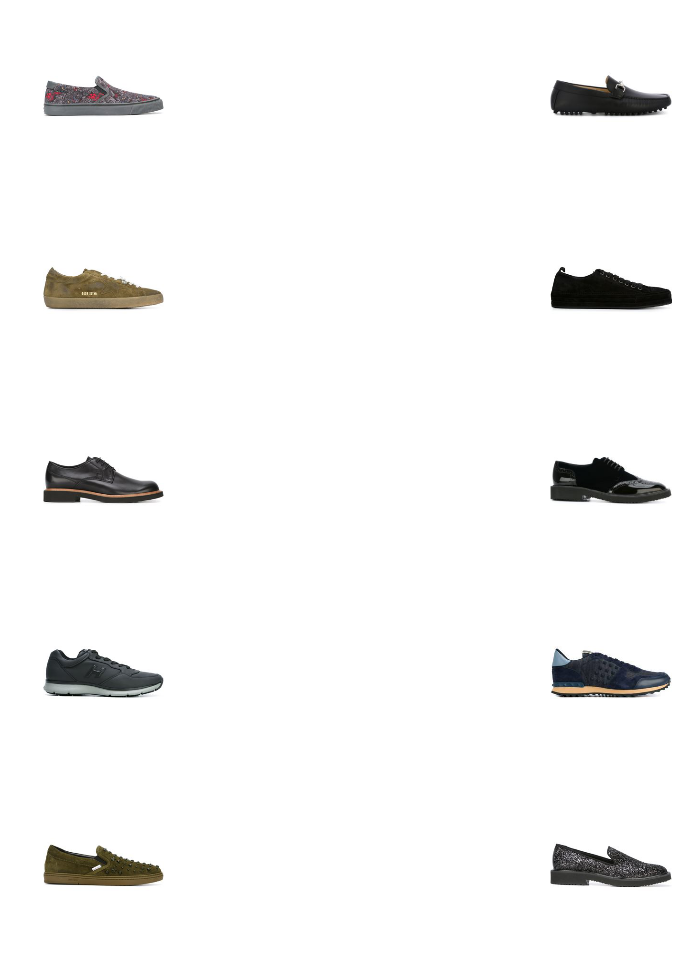

In [23]:
Norm3=Matrix_Normalise(Output3,[100,100,100,100])
Top_Image_Plot(Norm3,SL,measure=1)

Weighting:
[[           nan  1075.3283321   1053.41391452  1210.3618703 ]
 [           nan            nan   692.95139409  1246.23993161]
 [           nan            nan            nan  1244.38279023]
 [           nan            nan            nan            nan]]


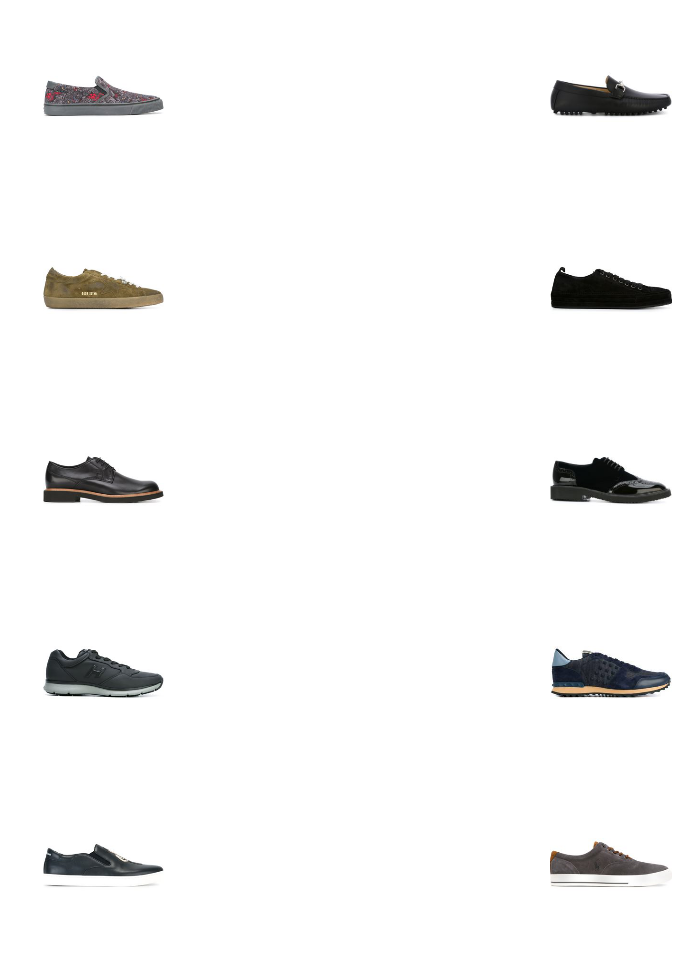

In [24]:
Norm4=Matrix_Normalise(Output4,[100,100,100,100])
Top_Image_Plot(Norm4,SL,measure=1)

Weighting:
[[           nan  5321.67866217  5170.39526245  5873.29977854]
 [           nan            nan  2847.93815152  6410.07967463]
 [           nan            nan            nan  6391.78290268]
 [           nan            nan            nan            nan]]


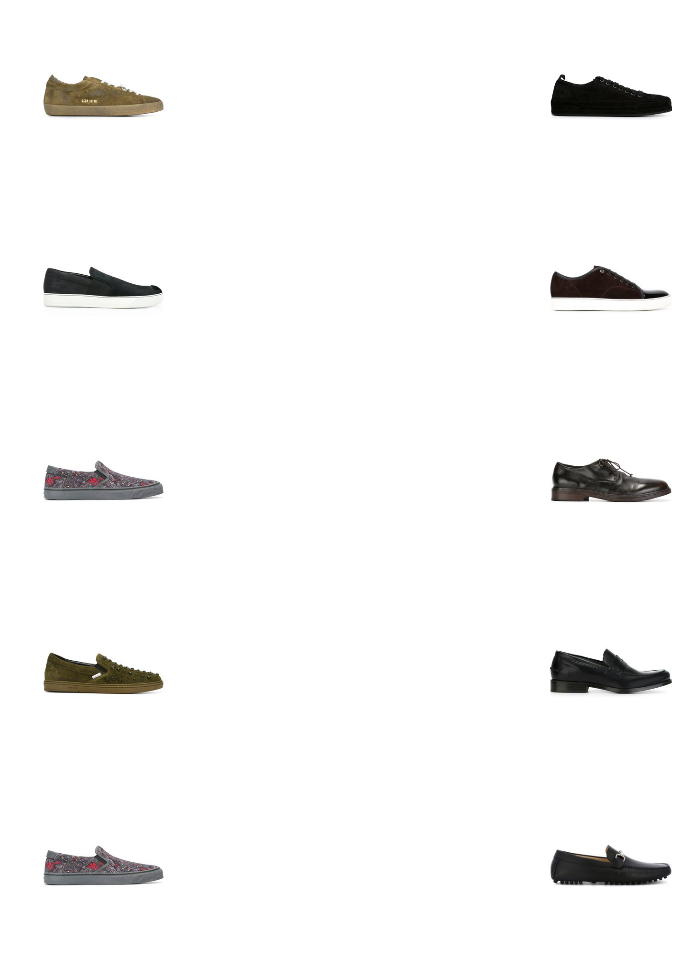

In [25]:
Norm5=Matrix_Normalise(Output5,[100,100,100,100])
Top_Image_Plot(Norm5,SL,measure=1)

The last three distance metrics have not performed as well, and the matches that have been provided, even from the same angle are not very good.

Now that I have tested the histogram comparison method I will apply it to images from outside the dataset and find the 5 closest matches to each image. I expect that the distance metric 2 will perform the best as it has done so here. Ideally I will re-run the calculations above to find the weightings for the entire dataset in order to compare images fairly and find the closest matches independent of the photo angle.